## Lab Assignment Four: Multi-Layer Perceptron

#### Luis Garduno

Dataset : https://www.kaggle.com/muonneutrino/us-census-demographic-data/data


--------------------------------

## 1. Load, Split, & Balance

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Loading Data & Adjustments

In [1]:
import numpy as np
import pandas as pd

# Load the data into memory & save it to a pandas data frame.
df = pd.read_csv("https://raw.githubusercontent.com/luisegarduno/MachineLearning_Projects/master/Datasets/acs2017_census_tract_data.csv");

# Zip State Name with ID number 
def_state = zip(df['State'].unique(), np.arange(52))

# Remove any observations having missing data.
df = df.dropna(axis=0, how='any')
del df['County']

# Encode State's as integers
df['State'] = pd.factorize(df.State)[0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Splitting the Dataset (10 points)

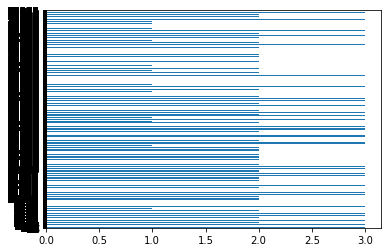

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# Divide 'ChildPoverty' into 4 classes
ChildPovertyClass = ['Okay', 'U.S. Poverty Rate', 'Very Poor', 'Extremely Poor']

# this creates a new variable
df['ChildPoverty_Class'] = pd.qcut(df['ChildPoverty'],[0.00,0.17,0.28,0.65,1.0],labels=False)

df['ChildPoverty_Class'].plot(kind='barh',alpha=1.0)
plt.show()

The following resources were used to gain an understanding of where the national poverty was during 2017.
- __[Child Poverty in America 2017: State Analysis](https://www.childrensdefense.org/wp-content/uploads/2018/09/Child-Poverty-in-America-2017-State-Fact-Sheet.pdf)__

- __[Child Poverty in America 2017: National Analysis](https://www.childrensdefense.org/wp-content/uploads/2018/09/Child-Poverty-in-America-2017-National-Fact-Sheet.pdf)__

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assume I'm equally interested in the classification performance for each class in the dataset.

# Create X data & y target dataframe's
if 'ChildPoverty' in df:
    y = df['ChildPoverty_Class'].values
    del df['ChildPoverty_Class']
    X = df.to_numpy()

# Notice we only perform fit_transform on X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Divide the data: 80% Training & 20% Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

print("Training Set", "\n   - Data Shape:",X_train.shape,"\n   - Target Shape:",y_train.shape)
print("\nTesting Set","\n   - Data Shape:",X_test.shape ,"\n   - Target Shape:",y_test.shape)

Training Set 
   - Data Shape: (58174, 36) 
   - Target Shape: (58174,)

Testing Set 
   - Data Shape: (14544, 36) 
   - Target Shape: (14544,)


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Balancing the Data

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA as RandomizedPCA

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=35,random_state=1)),
                    ('clf', LogisticRegression(class_weight='balanced', random_state=1, max_iter=500))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=ChildPovertyClass))

                   precision    recall  f1-score   support

             Okay       1.00      0.98      0.99      2447
U.S. Poverty Rate       0.85      1.00      0.92      1626
        Very Poor       1.00      0.96      0.98      5450
   Extremely Poor       1.00      1.00      1.00      5021

         accuracy                           0.98     14544
        macro avg       0.96      0.98      0.97     14544
     weighted avg       0.98      0.98      0.98     14544



In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.979
Fold: 2, Acc: 0.978
Fold: 3, Acc: 0.973
Fold: 4, Acc: 0.982
Fold: 5, Acc: 0.980
Fold: 6, Acc: 0.980
Fold: 7, Acc: 0.978
Fold: 8, Acc: 0.977
Fold: 9, Acc: 0.977
Fold: 10, Acc: 0.979

CV accuracy: 0.978 +/- 0.002


- Split 80/20. Balance 80, argue whether 20 should be balanced
- Explain reasoning for selecting this method for balancing the dataset. 
- Should balancing of the dataset be done for both the training & testing set? Explain.

If you do it to the test set, you're misrepresenting the reality of the dataset.
We do it on the training set so that our model doesn't overly classify just one child poverty rate.
But on the testing set we don't want to introduce new data or massage the data on a test set.
For the integrity of the data.

------------------------

## 2. Pre-Processing

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Quantifying Performance

In [ ]:
import sys
from scipy.special import expit

# Using the Two-Layer Perceptron network example (Mini-Batching & Glorant) provided during lecture,
# Let's quantify performance using accuracy. We don't normalize or one-hot encode the data just yet.

# start with a simple base classifier, which can't be fit or predicted it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """ Encode labels into one-hot representation """
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """ Initialize weights with small random numbers. """
        w1_num_elems = (self.n_features_ + 1)*self.n_hidden
        w1 = np.random.uniform(-1.0, 1.0,size=w1_num_elems)
        w1 = w1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W

        w2_num_elems = (self.n_hidden + 1)*self.n_output_
        w2 = np.random.uniform(-1.0, 1.0, size=w2_num_elems)
        w2 = w2.reshape(self.n_output_, self.n_hidden + 1)
        return w1, w2

    @staticmethod
    def _sigmoid(z):
        """ Use scipy.special.expit to avoid overflow """
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """ Add bias unit (column or row of 1s) to array at index 0 """
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            x_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            x_new = np.vstack((ones, X))
        return x_new

    @staticmethod
    def _L2_reg(lambda_, w1, w2):
        """ Compute L2-regularization cost """
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(w1[:, 1:] ** 2) + np.mean(w2[:, 1:] ** 2))

    def _cost(self,a3,y_enc,w1,w2):
        """ Get the objective function value """
        cost = -np.mean(np.nan_to_num((y_enc*np.log(a3)+(1-y_enc)*np.log(1-a3))))
        L2_term = self._L2_reg(self.l2_C, w1, w2)
        return cost + L2_term

    def _feedforward(self, X, w1, w2):
        """ Compute feedforward step """
        a1 = self._add_bias_unit(X, how='column')
        a1 = a1.T
        z1 = w1 @ a1
        a2 = self._sigmoid(z1)
        a2 = self._add_bias_unit(a2, how='row')
        z2 = w2 @ a2
        a3 = self._sigmoid(z2)
        return a1, z1, a2, z2, a3

    def _get_gradient(self, a1, a2, a3, z1, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation."""
        # vectorized backpropagation
        v2 = (a3-y_enc)  # <- this is only line that changed
        v1 = a2*(1-a2)*(w2.T @ v2)

        grad2 = v2 @ a2.T
        grad1 = v1[1:,:] @ a1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += w1[:, 1:] * self.l2_C
        grad2[:, 1:] += w2[:, 1:] * self.l2_C

        return grad1, grad2

    def predict(self, X):
        """ Predict class labels """
        _, _, _, _, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(a3, axis=0)
        return y_pred

In [ ]:
from sklearn.metrics import accuracy_score

# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True,minibatches=1, **kwds):
        # need to add to the original initializer
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        x_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = x_data.shape[1]
        self.n_output_ = y_enc.shape[0]
        self.w1, self.w2 = self._initialize_weights()

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(x_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                x_data, y_enc, y_data = x_data[idx_shuffle], y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                a1, z1, a2, z2, a3 = self._feedforward(x_data[idx], self.w1, self.w2)

                cost = self._cost(a3,y_enc[:, idx],self.w1,self.w2)
                mini_cost.append(cost)    # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z1=z1, z2=z2, y_enc=y_enc[:, idx], w1=self.w1,w2=self.w2)

                # momentum calculations
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(x_data)))

        return self

In [ ]:
class TLPGlorot(TLPMiniBatch):
    def __init__(self, dropout=0.25, **kwds):
        # need to add to the original initializer
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        w1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        w1[:,:1] = 0

        # reduce the final layer magnitude in order to balance the size of the gradients between
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        w2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        w2[:,:1] = 0

        return w1, w2

    def fit(self, X, y, print_progress=0, xy_test=None):
        """ Learn weights from training data. With mini-batch"""
        x_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = x_data.shape[1]
        self.n_output_ = y_enc.shape[0]
        self.w1, self.w2 = self._initialize_weights()

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(x_data)))
        if xy_test is not None:
            X_test = xy_test[0].copy()
            y_test = xy_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                x_data, y_enc, y_data = x_data[idx_shuffle], y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            # adding dropout neurons
            w1 = self.w1.copy()
            w2 = self.w2.copy()

            if self.dropout>0.0:

                # randomly select half of the neurons
                idx_dropout = np.random.permutation(w1.shape[0])
                #idx_other_half = idx_dropout[:int(w1.shape[0]*self.dropout)]
                idx_dropout = idx_dropout[int(w1.shape[0]*(1-self.dropout)):] #drop half

                idx_dropout = np.sort(idx_dropout)
                idx_w2_withbias = np.hstack(([0],(idx_dropout+1)))
                w1 = w1[idx_dropout,:]# get rid of rows
                w2 = w2[:,idx_w2_withbias]# get rid of extra columns
                delta_w1_prev_dropout = delta_w1_prev[idx_dropout,:]
                delta_w2_prev_dropout = delta_w2_prev[:,idx_w2_withbias]
            else:
                delta_w1_prev_dropout = delta_w1_prev
                delta_w2_prev_dropout = delta_w2_prev

            for idx in mini:

                # feedforward
                a1, z1, a2, z2, a3 = self._feedforward(x_data[idx], w1, w2)

                cost = self._cost(a3,y_enc[:, idx],w1,w2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z1=z1, z2=z2, y_enc=y_enc[:, idx], w1=w1,w2=w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                w1 -= (delta_w1 + (self.alpha * delta_w1_prev_dropout))
                w2 -= (delta_w2 + (self.alpha * delta_w2_prev_dropout))
                delta_w1_prev_dropout, delta_w2_prev_dropout = delta_w1, delta_w2

            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.w1[idx_dropout,:] = w1
                self.w2[:,idx_w2_withbias] = w2
                delta_w1_prev[idx_dropout,:] = delta_w1_prev_dropout
                delta_w2_prev[:,idx_w2_withbias] = delta_w2_prev_dropout
            else:
                # don't eliminate any neurons
                self.w1 = w1
                self.w2 = w2
                delta_w1_prev = delta_w1_prev_dropout
                delta_w2_prev = delta_w2_prev_dropout

            self.score_.append(accuracy_score(y_data,self.predict(x_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if xy_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

In [ ]:
plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))

    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))

    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')

    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Epoch: 3/100

CPU times: user 3.29 s, sys: 32.6 ms, total: 3.32 s
Wall time: 831 ms


Epoch: 10/10

CPU times: user 3.35 s, sys: 39.5 ms, total: 3.39 s
Wall time: 847 ms
Mini-Batch :
Resubstitution acc: 0.9065733832983808
Validation acc: 0.903052805280528
Glorot Initial :
Resubstitution acc: 0.9147213531818338
Validation acc: 0.914535203520352


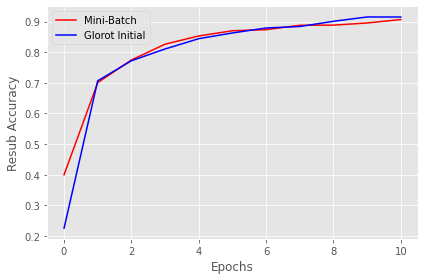

In [ ]:
vals = {'n_hidden':30,'C':0.01, 'epochs':10, 'eta':0.001, 'alpha':0.001,
        'decrease_const':1e-5, 'minibatches':50,'shuffle':True,'random_state':1}

nn_MiniBatch = TLPMiniBatch(**vals)
nn_Glorot = TLPGlorot(**vals, dropout=False)

%time nn_MiniBatch.fit(X_train, y_train, print_progress=1)
%time nn_Glorot.fit(X_train, y_train, print_progress=1)

print_result(nn_MiniBatch,X_train,y_train,X_test,y_test,title="Mini-Batch",color="red")
print_result(nn_Glorot,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

In [ ]:
# Be sure that training converges by graphing the loss function vs. # of epochs.
#params = dict(n_hidden=50, C=0.1, epochs=100, eta=0.001, random_state=1)
params = {'n_hidden':50, 'C':0.1, 'epochs':50, 'eta':0.001,'minibatches':50, 'random_state':1}

In [ ]:
%%time
nn_mini = TLPMiniBatch(**params)
nn_mini.fit(X_train, y_train, print_progress=1)
yhat_pred = nn_mini.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, yhat_pred.round(), normalize=False))

Epoch: 50/50

Test accuracy: 13997
CPU times: user 23.1 s, sys: 424 ms, total: 23.5 s
Wall time: 5.87 s


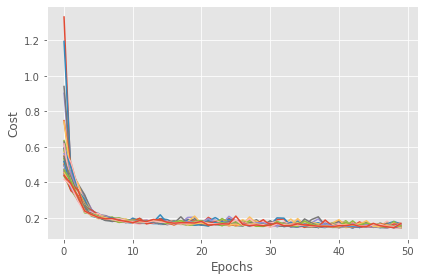

In [ ]:
plt.plot(range(len(nn_mini.cost_)), nn_mini.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Normalizing Data

In [ ]:
# Now normalize the continuous numeric feature data.
# Use the example two-layer perceptron network from the class example & quantify performance using accuracy.

In [ ]:
# Be sure that training converges by graphing the loss function vs. # of epochs.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Normalizing & One Hot Encoding the Data

In [ ]:
# Now normalize the continuous numeric feature data AND one hot encode the categorical data.
# Use the example two-layer perceptron network from the class example & quantify performance using accuracy.

In [ ]:
# Be sure that training converges by graphing the loss function vs. # of epochs.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Comparing the Models

In [ ]:
# Compare the performance of the three models I just trained.

- Are there any meaningful differences in performance?
- In my own words,explain why these models have (or don't have) different performances.
    - _Use one-hot encoding & normalization on the dataset for the remainder of this lab assignment._


------------------

## 3. Modeling

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Three-layer Support


In [ ]:
# Add sup for a third layer in the multi-layer perceptron.
# Add sup for saving(& plotting after training is completed) the avg magnitude of the gradient for each layer, for each epoch.

In [ ]:
# Quantify the performance of the model & graph the magnitudes for each layer Vs. the # of epochs.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Four-layer Support

In [ ]:
# Repeat the previous step, adding support for a fourth layer.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Five-layer Support

In [ ]:
# Repeat the previous step, adding support for a fifth layer.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.4 Adaptive Learning Technique w/ five-layer network

In [ ]:
# Implement an adaptive learning technique that was discussed in lecture & use it on the five layer network.
# Don't use AdaM for the adaptive learning technique. 

- Compare the performance of this model w/ & w/o the adaptive learning strategy.


---------------------------

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4. Adaptive Momentum
- 5000 level student: I have free reign to provide additional analyses.
- One idea: Implement adaptive momentum (AdaM) in the five layer neural network & quantify the performance. 


-----------------------

### Reference

Kaggle. US Census Demographics. https://www.kaggle.com/muonneutrino/us-census-demographic-data/data (Accessed 10-24-2020)